In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import stats

In [ ]:
# Load Dataset
# -------------------------
df = pd.read_csv("/content/imdb_query_plan_features_merged.csv")
target = "actual_execution_time"

drop_leaky_features = [
    "total_actual_rows", "total_actual_loops", "total_actual_time_node",
    "output_rows", "rows_estimate_error", "rows_estimate_ratio",
    "output_row_estimation_error", "output_row_estimation_ratio",
    "cost_time_ratio", "sum_node_actual_time_vs_total_actual_time_ratio",
    target, "query_id"
]
X = df.drop(columns=drop_leaky_features, errors="ignore")
y_raw = df[target]


In [ ]:
# Log-transform target
y_log = np.log1p(y_raw)

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


                              Correlation_with_target
plan_total_cost                              0.678565
plan_startup_cost                            0.674188
total_estimated_rows                         0.668199
total_estimated_bytes                        0.641065
plan_rows                                    0.148989
has_hash                                     0.014972
has_group_by                                 0.014443
node_type_Merge Join_count                  -0.015317
node_type_Materialize_count                 -0.016253
node_type_Aggregate_count                   -0.017856
node_type_Sort_count                        -0.023788
node_type_Gather Merge_count                -0.040242
query_planning_time                         -0.040544
node_type_Nested Loop_count                 -0.042787
num_aggregate_functions                     -0.043698
num_where_conditions                        -0.124353
node_type_Gather_count                      -0.154308
node_type_OTHER_count       

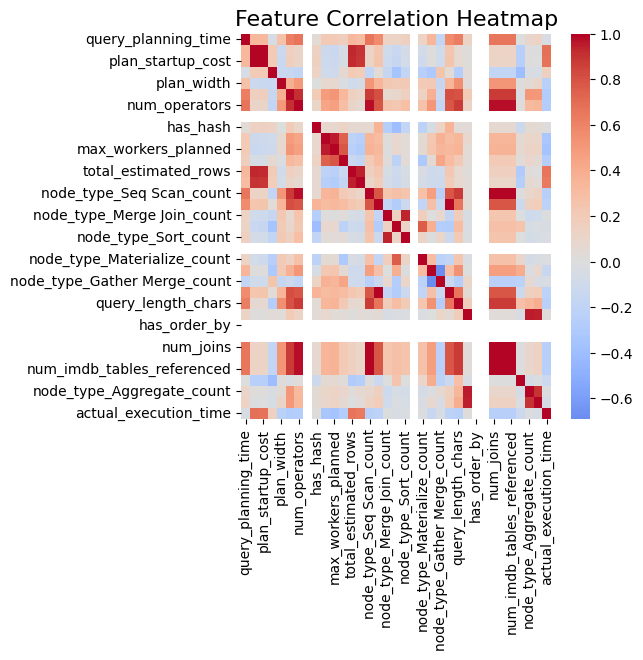

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Correlation with target ---
corr_with_target = X.corrwith(y_raw)

# Convert to DataFrame for better display
corr_df = corr_with_target.to_frame(name="Correlation_with_target").sort_values(
    by="Correlation_with_target", ascending=False
)

print(corr_df)

# --- Heatmap ---
# Combine features + target for full correlation matrix
corr_matrix = pd.concat([X, y_raw], axis=1).corr()

plt.figure(figsize=(5, 5))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=False,   # set True if you want numbers
    fmt=".2f",
    cbar=True
)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()


In [ ]:
# -------------------------
# Target Variables
# -------------------------
y_raw = df["actual_execution_time"]          # before log
y_log = np.log1p(y_raw)                      # after log

# -------------------------
# Outlier Ranges
# -------------------------
def outlier_ranges(data, method="IQR"):
    if method == "IQR":
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
    elif method == "Z":
        mean = np.mean(data)
        std = np.std(data)
        lower = mean - 3 * std
        upper = mean + 3 * std
    return lower, upper

# Before log
iqr_raw = outlier_ranges(y_raw, method="IQR")
z_raw   = outlier_ranges(y_raw, method="Z")

# After log
iqr_log = outlier_ranges(y_log, method="IQR")
z_log   = outlier_ranges(y_log, method="Z")

print("🔹 Before Log Transformation")
print(f"IQR method: below {iqr_raw[0]:.2f} or above {iqr_raw[1]:.2f}")
print(f"Z-score method: below {z_raw[0]:.2f} or above {z_raw[1]:.2f}\n")

print("🔹 After Log Transformation")
print(f"IQR method: below {iqr_log[0]:.2f} or above {iqr_log[1]:.2f}")
print(f"Z-score method: below {z_log[0]:.2f} or above {z_log[1]:.2f}")

# -------------------------
# Outlier Counts
# -------------------------
def iqr_outliers_count(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((data < lower) | (data > upper)).sum()

def z_outliers_count(data):
    z_scores = stats.zscore(data)
    return (np.abs(z_scores) > 3).sum()

# Counts
iqr_raw_count = iqr_outliers_count(y_raw)
z_raw_count   = z_outliers_count(y_raw)

iqr_log_count = iqr_outliers_count(y_log)
z_log_count   = z_outliers_count(y_log)

print("\n🔹 Before Log Transformation")
print(f"IQR: {iqr_raw_count} outliers")
print(f"Z-score: {z_raw_count} outliers\n")

print("🔹 After Log Transformation")
print(f"IQR: {iqr_log_count} outliers")
print(f"Z-score: {z_log_count} outliers")


🔹 Before Log Transformation
IQR method: below 0.83 or above 18.83
Z-score method: below -9306.77 or above 11368.66

🔹 After Log Transformation
IQR method: below 1.52 or above 3.20
Z-score method: below -4.06 or above 10.18

🔹 Before Log Transformation
IQR: 2360 outliers
Z-score: 325 outliers

🔹 After Log Transformation
IQR: 2373 outliers
Z-score: 16 outliers


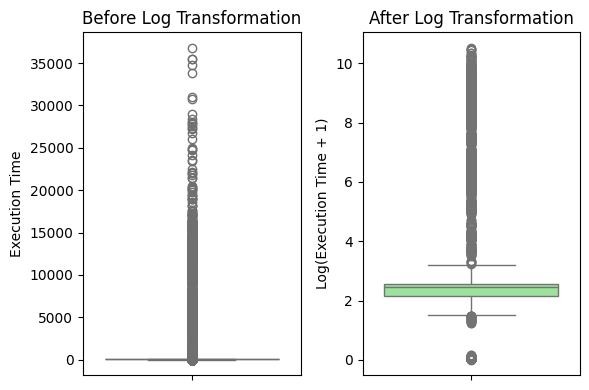

In [ ]:
# Plot side by side boxplots
y_raw = df[target]
y_log = np.log1p(y_raw)
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Before transformation
sns.boxplot(y=y_raw, ax=axes[0], color="skyblue")
axes[0].set_title("Before Log Transformation")
axes[0].set_ylabel("Execution Time")

# After transformation
sns.boxplot(y=y_log, ax=axes[1], color="lightgreen")
axes[1].set_title("After Log Transformation")
axes[1].set_ylabel("Log(Execution Time + 1)")

plt.tight_layout()
plt.show()

CONCLUSION:

Z-score method → absolute cutoff using mean & std (not good with skewed data).

IQR method → cutoff using percentiles (Q1, Q3) (better for skewed data, like execution times).

Z-score method: "How far is a point from the mean in terms of standard deviations?"

IQR method: "Does the point lie outside the ‘typical middle 50%’ range of the data?"

In [ ]:
y_log = np.log1p(df["actual_execution_time"])

mean_log = y_log.mean()
std_log = y_log.std()

lower_bound = mean_log - 3 * std_log
upper_bound = mean_log + 3 * std_log

print(f"Log-space bounds: {lower_bound:.2f} – {upper_bound:.2f}")


Log-space bounds: -4.06 – 10.18


In [ ]:
# -------------------------
# Train / Validation / Test Split
# -------------------------
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

# -------------------------
# Handle Missing Values
# -------------------------
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val   = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# -------------------------
# Custom Metrics
# -------------------------
def adjusted_r2(r2, n, k):
    return 1 - (1-r2) * (n-1)/(n-k-1)

def accuracy_within_tolerance(y_true, y_pred, tol=0.10):
    # revert log1p back to original scale
    y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)
    tolerance = tol * np.abs(y_true)
    within_tol = np.abs(y_pred - y_true) <= tolerance
    return np.mean(within_tol) * 100

def evaluate_model_full(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    results = {}
    for split, X_, y_ in [("Train", X_train, y_train),
                          ("Validation", X_val, y_val),
                          ("Test", X_test, y_test)]:
        y_pred = model.predict(X_)

        # Metrics in log-space
        mse = mean_squared_error(y_, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_, y_pred)
        r2 = r2_score(y_, y_pred)
        adj_r2 = adjusted_r2(r2, X_.shape[0], X_.shape[1])

        # Metrics in original scale
        acc10 = accuracy_within_tolerance(y_, y_pred, tol=0.10)
        acc20 = accuracy_within_tolerance(y_, y_pred, tol=0.20)
        acc30 = accuracy_within_tolerance(y_, y_pred, tol=0.30)

        results[split] = {
            "MSE": mse, "RMSE": rmse, "MAE": mae,
            "R2": r2, "AdjR2": adj_r2,
            "Acc@10%": acc10, "Acc@20%": acc20, "Acc@30%": acc30
        }

    print(f"\n📊 {name} Results:")
    for split in ["Train", "Validation", "Test"]:
        metrics = results[split]
        print(f"  {split}: MSE={metrics['MSE']:.2f}, RMSE={metrics['RMSE']:.2f}, "
              f"MAE={metrics['MAE']:.2f}, R²={metrics['R2']:.4f}, "
              f"AdjR²={metrics['AdjR2']:.4f}, "
              f"Acc@10%={metrics['Acc@10%']:.2f}%, "
              f"Acc@20%={metrics['Acc@20%']:.2f}%, "
              f"Acc@30%={metrics['Acc@30%']:.2f}%")
    return results

def grid_search_model(name, model, param_grid, X_train, y_train):
    grid = GridSearchCV(model, param_grid, cv=3, scoring="r2", n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print(f"\n🔎 {name} Best Params: {grid.best_params_}")
    return grid.best_estimator_

# -------------------------
# Models + Hyperparameter Grids
# -------------------------
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, None],
        "max_features": ["sqrt", "log2"]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [6, 10],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "max_depth": [4, 6],
        "learning_rate": [0.05, 0.1]
    },
    "Linear Regression": {
        "linearregression__fit_intercept": [True, False],
        "linearregression__positive": [True, False]
    },
    "SVR": {
        "svr__kernel": ["linear", "rbf"],
        "svr__C": [0.1, 1, 10],
        "svr__gamma": ["scale", "auto"]
    }
}

# -------------------------
# Train & Evaluate Models
# -------------------------
results = []

# Random Forest
rf_best = grid_search_model("Random Forest",
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grids["Random Forest"], X_train, y_train)
rf_metrics = evaluate_model_full("Random Forest", rf_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("Random Forest", rf_best, rf_metrics["Validation"]["R2"]))

# XGBoost
xgb_best = grid_search_model("XGBoost",
    XGBRegressor(random_state=42, n_jobs=-1),
    param_grids["XGBoost"], X_train, y_train)
xgb_metrics = evaluate_model_full("XGBoost", xgb_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("XGBoost", xgb_best, xgb_metrics["Validation"]["R2"]))

# Gradient Boosting
gb_best = grid_search_model("Gradient Boosting",
    GradientBoostingRegressor(random_state=42),
    param_grids["Gradient Boosting"], X_train, y_train)
gb_metrics = evaluate_model_full("Gradient Boosting", gb_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("Gradient Boosting", gb_best, gb_metrics["Validation"]["R2"]))

# Linear Regression
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("linearregression", LinearRegression())
])
lr_best = grid_search_model("Linear Regression", lr_pipe,
                            param_grids["Linear Regression"], X_train, y_train)
lr_metrics = evaluate_model_full("Linear Regression", lr_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("Linear Regression", lr_best, lr_metrics["Validation"]["R2"]))

# SVR
svr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])
svr_best = grid_search_model("SVR", svr_pipe, param_grids["SVR"], X_train, y_train)
svr_metrics = evaluate_model_full("SVR", svr_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("SVR", svr_best, svr_metrics["Validation"]["R2"]))

# -------------------------
# Select & Save Best Model
# -------------------------
best_model_name, best_model, _ = max(results, key=lambda x: x[2])
print(f"\n🏆 Best Model: {best_model_name}")
joblib.dump(best_model, f"best_{best_model_name.replace(' ', '_').lower()}.pkl")


Fitting 3 folds for each of 8 candidates, totalling 24 fits

🔎 Random Forest Best Params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

📊 Random Forest Results:
  Train: MSE=0.08, RMSE=0.28, MAE=0.14, R²=0.9864, AdjR²=0.9863, Acc@10%=58.69%, Acc@20%=77.28%, Acc@30%=85.60%
  Validation: MSE=0.57, RMSE=0.76, MAE=0.39, R²=0.8981, AdjR²=0.8959, Acc@10%=26.63%, Acc@20%=49.53%, Acc@30%=63.60%
  Test: MSE=0.52, RMSE=0.72, MAE=0.36, R²=0.9068, AdjR²=0.9048, Acc@10%=27.32%, Acc@20%=51.65%, Acc@30%=63.97%
Fitting 3 folds for each of 16 candidates, totalling 48 fits

🔎 XGBoost Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

📊 XGBoost Results:
  Train: MSE=0.06, RMSE=0.25, MAE=0.16, R²=0.9894, AdjR²=0.9893, Acc@10%=34.59%, Acc@20%=60.91%, Acc@30%=75.27%
  Validation: MSE=0.63, RMSE=0.79, MAE=0.40, R²=0.8875, AdjR²=0.8851, Acc@10%=20.78%, Acc@20%=42.87%, Acc@30%=58.43%
  Test: MSE=0.53, RMSE=0.73, MAE=0.37, R²=0.9043, AdjR²=0.9022, Acc

['best_gradient_boosting.pkl']

###TRIMMING

In [ ]:
df_trimmed = df[(y_log >= lower_bound) & (y_log <= upper_bound)].copy()

print(f"Original size: {len(df)}")
print(f"After trimming: {len(df_trimmed)}")
print(f"Removed {len(df) - len(df_trimmed)} outliers (log-space)")


Original size: 8034
After trimming: 8018
Removed 16 outliers (log-space)


In [ ]:
# -------------------------
# Target Transformation
# -------------------------
y_log = np.log1p(y_raw)   # log1p is safer than log, handles zeros

# -------------------------
# Train / Validation / Test Split
# -------------------------
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

# -------------------------
# Handle Missing Values
# -------------------------
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val   = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# -------------------------
# Custom Metrics
# -------------------------
def adjusted_r2(r2, n, k):
    return 1 - (1-r2) * (n-1)/(n-k-1)

def accuracy_within_tolerance(y_true, y_pred, tol=0.10):
    # revert log1p back to original scale
    y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)
    tolerance = tol * np.abs(y_true)
    within_tol = np.abs(y_pred - y_true) <= tolerance
    return np.mean(within_tol) * 100

def evaluate_model_full(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    results = {}
    for split, X_, y_ in [("Train", X_train, y_train),
                          ("Validation", X_val, y_val),
                          ("Test", X_test, y_test)]:
        y_pred = model.predict(X_)

        # Metrics in log-space
        mse = mean_squared_error(y_, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_, y_pred)
        r2 = r2_score(y_, y_pred)
        adj_r2 = adjusted_r2(r2, X_.shape[0], X_.shape[1])

        # Metrics in original scale
        acc10 = accuracy_within_tolerance(y_, y_pred, tol=0.10)
        acc20 = accuracy_within_tolerance(y_, y_pred, tol=0.20)
        acc30 = accuracy_within_tolerance(y_, y_pred, tol=0.30)

        results[split] = {
            "MSE": mse, "RMSE": rmse, "MAE": mae,
            "R2": r2, "AdjR2": adj_r2,
            "Acc@10%": acc10, "Acc@20%": acc20, "Acc@30%": acc30
        }

    print(f"\n📊 {name} Results:")
    for split in ["Train", "Validation", "Test"]:
        metrics = results[split]
        print(f"  {split}: MSE={metrics['MSE']:.2f}, RMSE={metrics['RMSE']:.2f}, "
              f"MAE={metrics['MAE']:.2f}, R²={metrics['R2']:.4f}, "
              f"AdjR²={metrics['AdjR2']:.4f}, "
              f"Acc@10%={metrics['Acc@10%']:.2f}%, "
              f"Acc@20%={metrics['Acc@20%']:.2f}%, "
              f"Acc@30%={metrics['Acc@30%']:.2f}%")
    return results

def grid_search_model(name, model, param_grid, X_train, y_train):
    grid = GridSearchCV(model, param_grid, cv=3, scoring="r2", n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print(f"\n🔎 {name} Best Params: {grid.best_params_}")
    return grid.best_estimator_

# -------------------------
# Models + Hyperparameter Grids
# -------------------------
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, None],
        "max_features": ["sqrt", "log2"]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [6, 10],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "max_depth": [4, 6],
        "learning_rate": [0.05, 0.1]
    },
    "Linear Regression": {
        "linearregression__fit_intercept": [True, False],
        "linearregression__positive": [True, False]
    },
    "SVR": {
        "svr__kernel": ["linear", "rbf"],
        "svr__C": [0.1, 1, 10],
        "svr__gamma": ["scale", "auto"]
    }
}

# -------------------------
# Train & Evaluate Models
# -------------------------
results = []

# Random Forest
rf_best = grid_search_model("Random Forest",
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grids["Random Forest"], X_train, y_train)
rf_metrics = evaluate_model_full("Random Forest", rf_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("Random Forest", rf_best, rf_metrics["Validation"]["R2"]))

# XGBoost
xgb_best = grid_search_model("XGBoost",
    XGBRegressor(random_state=42, n_jobs=-1),
    param_grids["XGBoost"], X_train, y_train)
xgb_metrics = evaluate_model_full("XGBoost", xgb_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("XGBoost", xgb_best, xgb_metrics["Validation"]["R2"]))

# Gradient Boosting
gb_best = grid_search_model("Gradient Boosting",
    GradientBoostingRegressor(random_state=42),
    param_grids["Gradient Boosting"], X_train, y_train)
gb_metrics = evaluate_model_full("Gradient Boosting", gb_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("Gradient Boosting", gb_best, gb_metrics["Validation"]["R2"]))

# Linear Regression
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("linearregression", LinearRegression())
])
lr_best = grid_search_model("Linear Regression", lr_pipe,
                            param_grids["Linear Regression"], X_train, y_train)
lr_metrics = evaluate_model_full("Linear Regression", lr_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("Linear Regression", lr_best, lr_metrics["Validation"]["R2"]))

# SVR
svr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])
svr_best = grid_search_model("SVR", svr_pipe, param_grids["SVR"], X_train, y_train)
svr_metrics = evaluate_model_full("SVR", svr_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("SVR", svr_best, svr_metrics["Validation"]["R2"]))

# -------------------------
# Select & Save Best Model
# -------------------------
best_model_name, best_model, _ = max(results, key=lambda x: x[2])
print(f"\n🏆 Best Model: {best_model_name}")
joblib.dump(best_model, f"best_{best_model_name.replace(' ', '_').lower()}.pkl")


Fitting 3 folds for each of 8 candidates, totalling 24 fits

🔎 Random Forest Best Params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

📊 Random Forest Results:
  Train: MSE=0.08, RMSE=0.28, MAE=0.14, R²=0.9864, AdjR²=0.9863, Acc@10%=58.69%, Acc@20%=77.28%, Acc@30%=85.60%
  Validation: MSE=0.57, RMSE=0.76, MAE=0.39, R²=0.8981, AdjR²=0.8959, Acc@10%=26.63%, Acc@20%=49.53%, Acc@30%=63.60%
  Test: MSE=0.52, RMSE=0.72, MAE=0.36, R²=0.9068, AdjR²=0.9048, Acc@10%=27.32%, Acc@20%=51.65%, Acc@30%=63.97%
Fitting 3 folds for each of 16 candidates, totalling 48 fits

🔎 XGBoost Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

📊 XGBoost Results:
  Train: MSE=0.06, RMSE=0.25, MAE=0.16, R²=0.9894, AdjR²=0.9893, Acc@10%=34.59%, Acc@20%=60.91%, Acc@30%=75.27%
  Validation: MSE=0.63, RMSE=0.79, MAE=0.40, R²=0.8875, AdjR²=0.8851, Acc@10%=20.78%, Acc@20%=42.87%, Acc@30%=58.43%
  Test: MSE=0.53, RMSE=0.73, MAE=0.37, R²=0.9043, AdjR²=0.9022, Acc

['best_gradient_boosting.pkl']


📊 Random Forest Results:
  Train: MSE=0.08, RMSE=0.28, MAE=0.14, R²=0.9864, AdjR²=0.9863, Acc@10%=58.69%, Acc@20%=77.28%, Acc@30%=85.60%
  Validation: MSE=0.57, RMSE=0.76, MAE=0.39, R²=0.8981, AdjR²=0.8959, Acc@10%=26.63%, Acc@20%=49.53%, Acc@30%=63.60%
  Test: MSE=0.52, RMSE=0.72, MAE=0.36, R²=0.9068, AdjR²=0.9048, Acc@10%=27.32%, Acc@20%=51.65%, Acc@30%=63.97%

📊 XGBoost Results:
  Train: MSE=0.06, RMSE=0.25, MAE=0.16, R²=0.9894, AdjR²=0.9893, Acc@10%=34.59%, Acc@20%=60.91%, Acc@30%=75.27%
  Validation: MSE=0.63, RMSE=0.79, MAE=0.40, R²=0.8875, AdjR²=0.8851, Acc@10%=20.78%, Acc@20%=42.87%, Acc@30%=58.43%
  Test: MSE=0.53, RMSE=0.73, MAE=0.37, R²=0.9043, AdjR²=0.9022, Acc@10%=23.09%, Acc@20%=43.50%, Acc@30%=57.75%

📊 Gradient Boosting Results:
  Train: MSE=0.13, RMSE=0.36, MAE=0.22, R²=0.9773, AdjR²=0.9771, Acc@10%=29.27%, Acc@20%=53.71%, Acc@30%=68.09%
  Validation: MSE=0.55, RMSE=0.74, MAE=0.37, R²=0.9015, AdjR²=0.8994, Acc@10%=22.65%, Acc@20%=44.87%, Acc@30%=61.23%
  Test: MSE=0.5

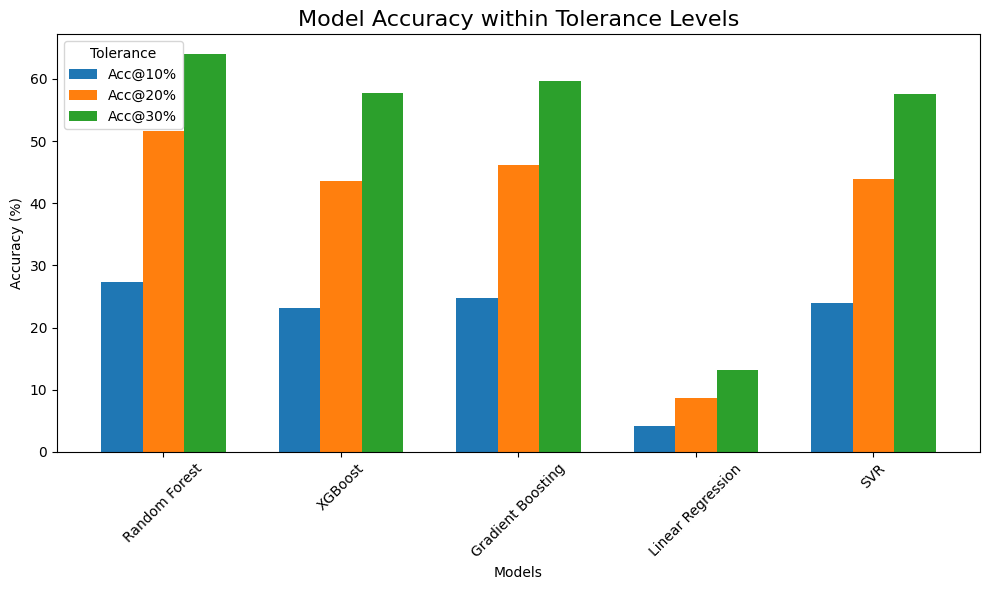

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------
# Collect accuracy results
# -------------------------
acc_results = []

for name, model, _ in results:
    # Each model has metrics in Train/Validation/Test, we’ll use Test set
    metrics = evaluate_model_full(name, model, X_train, y_train, X_val, y_val, X_test, y_test)
    acc_results.append({
        "Model": name,
        "Acc@10%": metrics["Test"]["Acc@10%"],
        "Acc@20%": metrics["Test"]["Acc@20%"],
        "Acc@30%": metrics["Test"]["Acc@30%"]
    })

# Convert to DataFrame
acc_df = pd.DataFrame(acc_results)
print(acc_df)

# -------------------------
# Plot grouped bar chart
# -------------------------
acc_df.set_index("Model")[["Acc@10%","Acc@20%","Acc@30%"]].plot(
    kind="bar", figsize=(10,6), width=0.7
)

plt.title("Model Accuracy within Tolerance Levels", fontsize=16)
plt.ylabel("Accuracy (%)")
plt.xlabel("Models")
plt.legend(title="Tolerance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


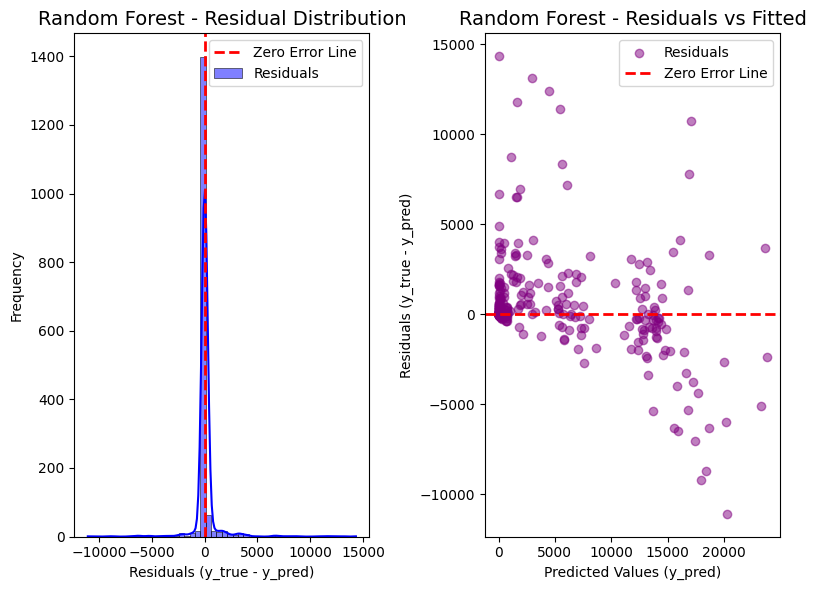

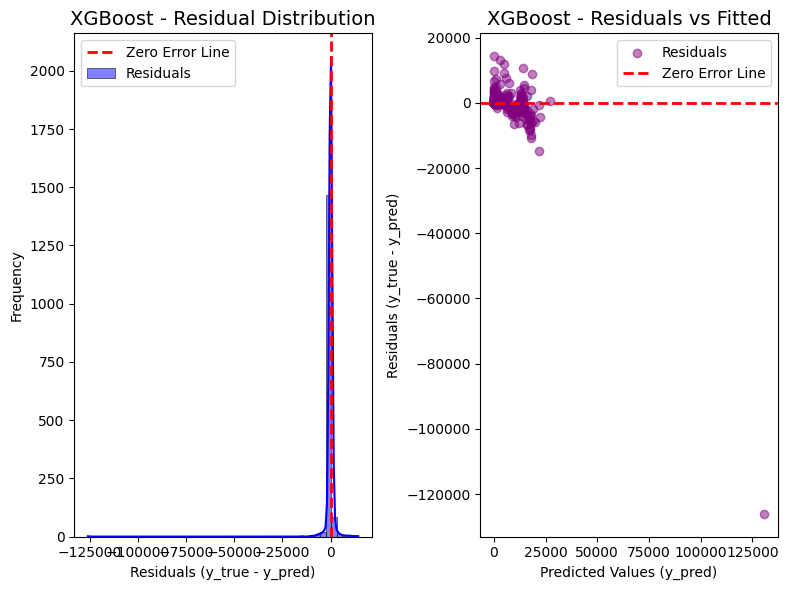

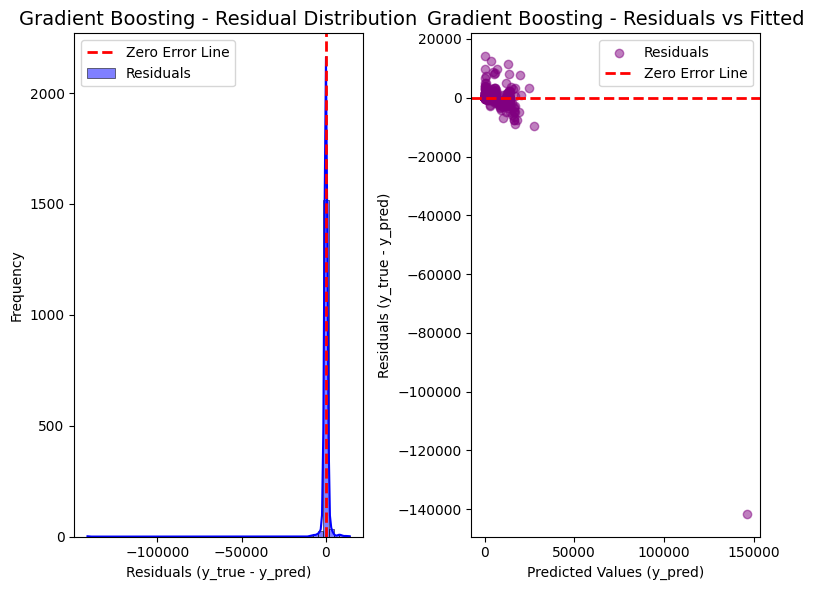

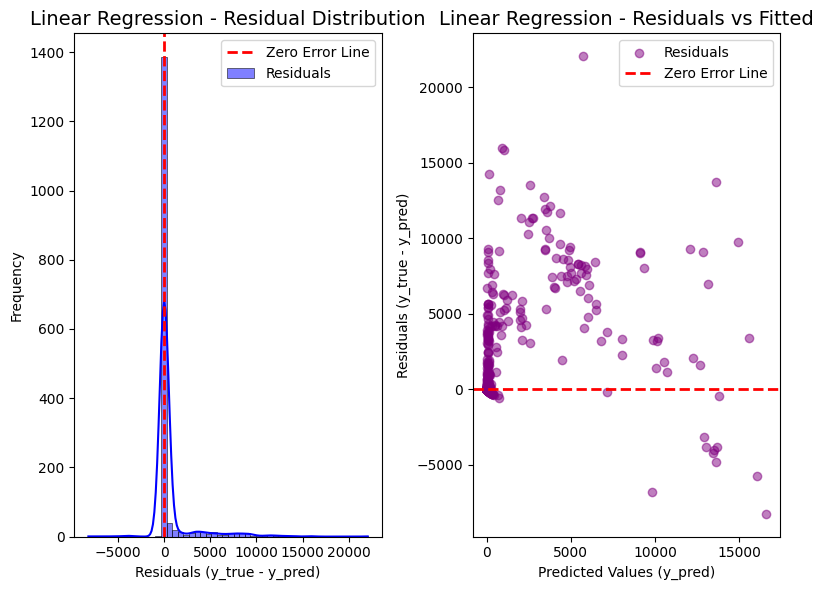

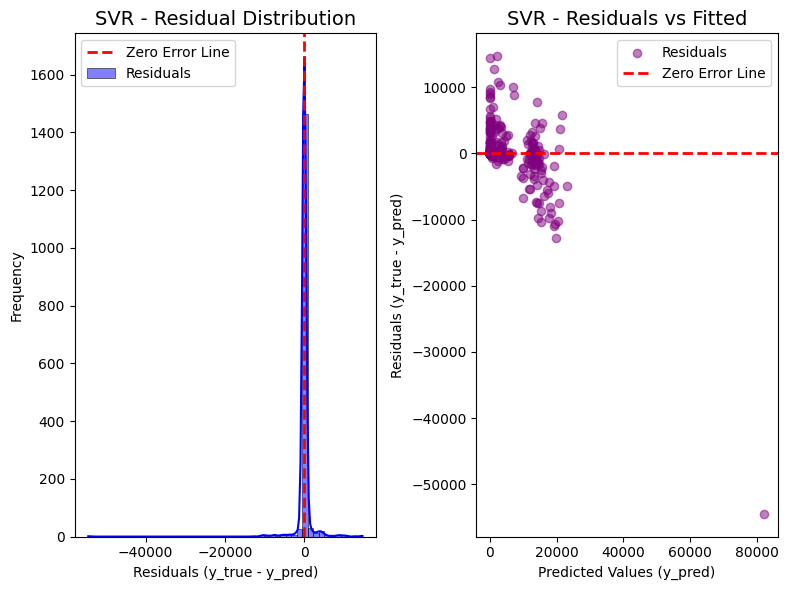

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------
# Residual Plot Function
# -------------------------
def plot_residuals(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # revert log1p for interpretability
    y_true_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)

    residuals = y_true_exp - y_pred_exp

    fig, axes = plt.subplots(1, 2, figsize=(8, 6))

    # 1. Residual Distribution
    sns.histplot(residuals, bins=50, kde=True, color="blue", ax=axes[0], label="Residuals")
    axes[0].axvline(0, color="red", linestyle="--", linewidth=2, label="Zero Error Line")
    axes[0].set_title(f"{model_name} - Residual Distribution", fontsize=14)
    axes[0].set_xlabel("Residuals (y_true - y_pred)")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()

    # 2. Residuals vs Fitted
    axes[1].scatter(y_pred_exp, residuals, alpha=0.5, color="purple", label="Residuals")
    axes[1].axhline(0, color="red", linestyle="--", linewidth=2, label="Zero Error Line")
    axes[1].set_title(f"{model_name} - Residuals vs Fitted", fontsize=14)
    axes[1].set_xlabel("Predicted Values (y_pred)")
    axes[1].set_ylabel("Residuals (y_true - y_pred)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# -------------------------
# Plot residuals for all models
# -------------------------
models_and_names = [
    ("Random Forest", rf_best),
    ("XGBoost", xgb_best),
    ("Gradient Boosting", gb_best),
    ("Linear Regression", lr_best),
    ("SVR", svr_best),
]

for name, model in models_and_names:
    plot_residuals(model, X_test, y_test, name)


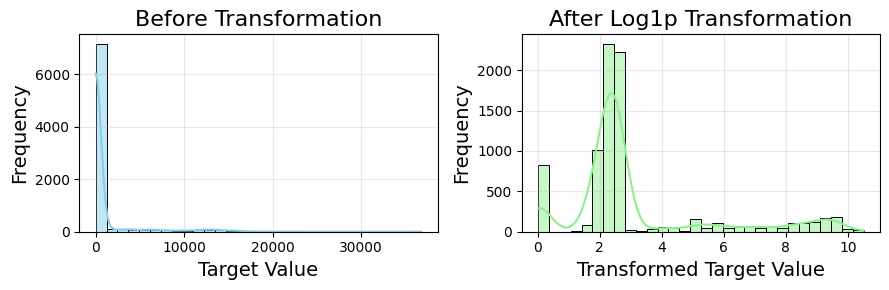

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Original target
y_raw = df["actual_execution_time"]

# Log-transformed target
y_transformed = np.log1p(y_raw)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Before transformation
sns.histplot(y_raw, bins=30, kde=True, color="skyblue", edgecolor="black", ax=axes[0])
axes[0].set_title("Before Transformation", fontsize=16)
axes[0].set_xlabel("Target Value", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].grid(True, alpha=0.3)

# After transformation
sns.histplot(y_transformed, bins=30, kde=True, color="lightgreen", edgecolor="black", ax=axes[1])
axes[1].set_title("After Log1p Transformation", fontsize=16)
axes[1].set_xlabel("Transformed Target Value", fontsize=14)
axes[1].set_ylabel("Frequency", fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
print("Skewness before:", y_raw.skew())
print("Skewness after log1p:", y_transformed.skew())


Skewness before: 4.2609651117773195
Skewness after log1p: 1.5662085567225044


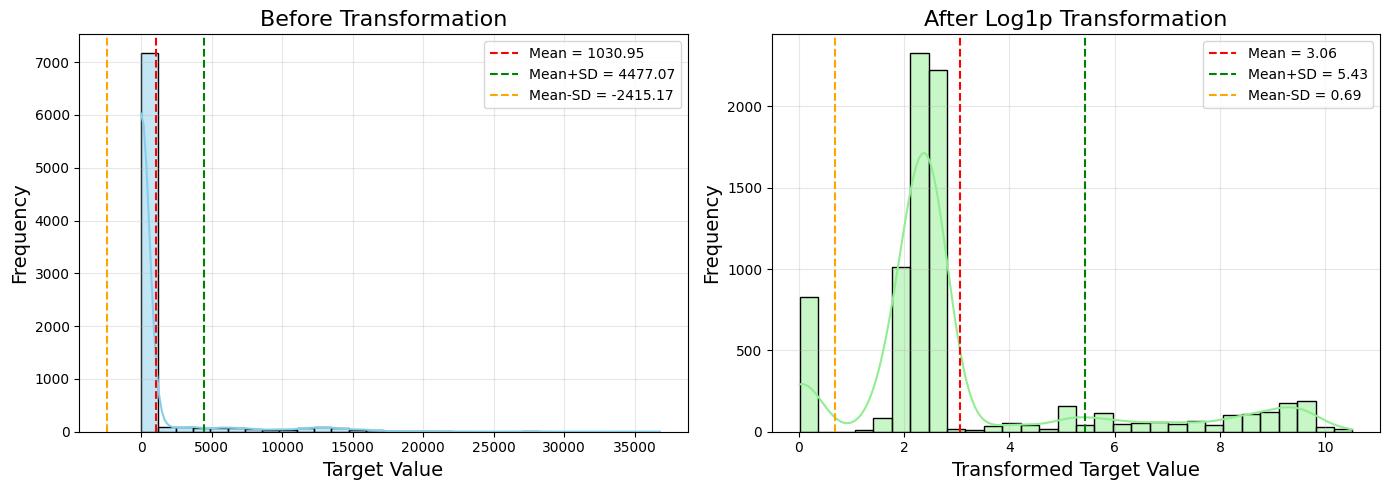

📊 Summary Statistics:
Before Transformation: Mean=1030.95, Std=3446.12
After Log1p Transformation: Mean=3.06, Std=2.37


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Original target
y_raw = df["actual_execution_time"]

# Log-transformed target
y_transformed = np.log1p(y_raw)

# Compute mean and std
mean_raw, std_raw = y_raw.mean(), y_raw.std()
mean_trans, std_trans = y_transformed.mean(), y_transformed.std()

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before transformation
sns.histplot(y_raw, bins=30, kde=True, color="skyblue", edgecolor="black", ax=axes[0])
axes[0].set_title("Before Transformation", fontsize=16)
axes[0].set_xlabel("Target Value", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].axvline(mean_raw, color='red', linestyle='--', label=f"Mean = {mean_raw:.2f}")
axes[0].axvline(mean_raw + std_raw, color='green', linestyle='--', label=f"Mean+SD = {mean_raw+std_raw:.2f}")
axes[0].axvline(mean_raw - std_raw, color='orange', linestyle='--', label=f"Mean-SD = {mean_raw-std_raw:.2f}")
axes[0].legend()

# After transformation
sns.histplot(y_transformed, bins=30, kde=True, color="lightgreen", edgecolor="black", ax=axes[1])
axes[1].set_title("After Log1p Transformation", fontsize=16)
axes[1].set_xlabel("Transformed Target Value", fontsize=14)
axes[1].set_ylabel("Frequency", fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(mean_trans, color='red', linestyle='--', label=f"Mean = {mean_trans:.2f}")
axes[1].axvline(mean_trans + std_trans, color='green', linestyle='--', label=f"Mean+SD = {mean_trans+std_trans:.2f}")
axes[1].axvline(mean_trans - std_trans, color='orange', linestyle='--', label=f"Mean-SD = {mean_trans-std_trans:.2f}")
axes[1].legend()

plt.tight_layout()
plt.show()

print("📊 Summary Statistics:")
print(f"Before Transformation: Mean={mean_raw:.2f}, Std={std_raw:.2f}")
print(f"After Log1p Transformation: Mean={mean_trans:.2f}, Std={std_trans:.2f}")


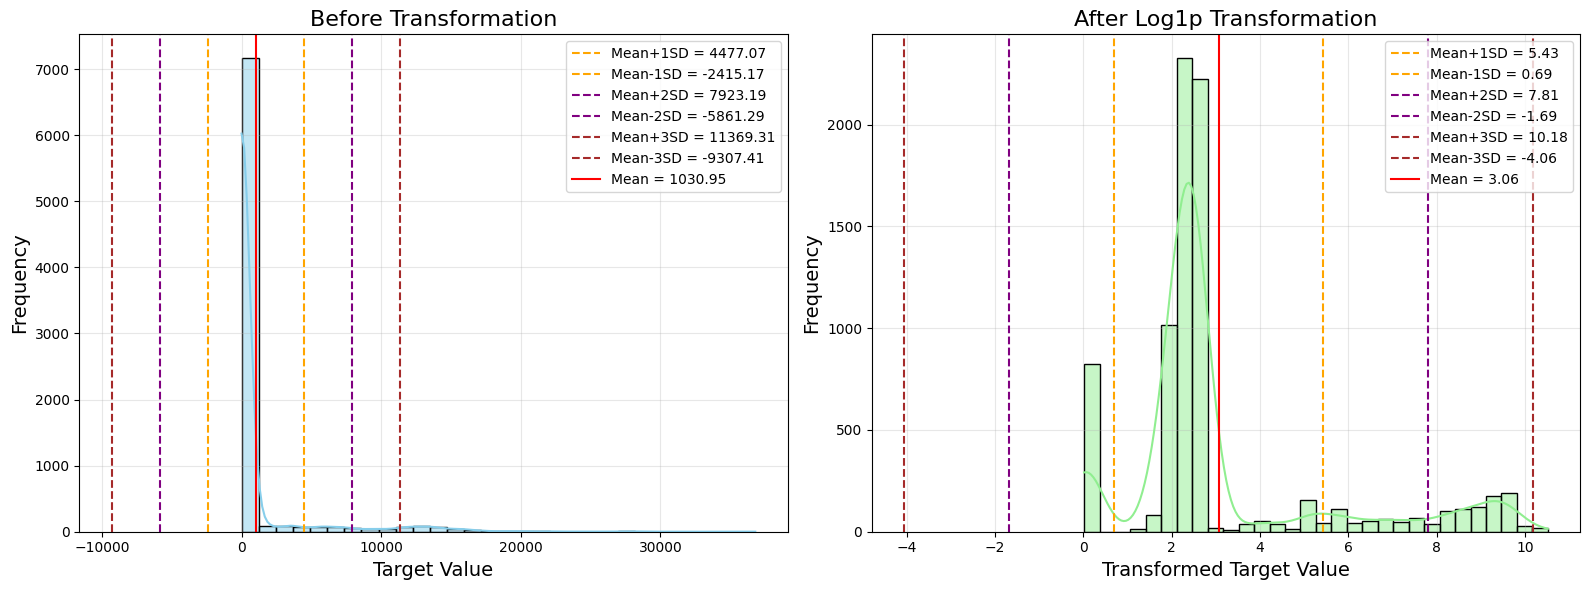

📊 Summary Statistics:
Before Transformation: Mean=1030.95, Std=3446.12
  Mean ± 1SD: [-2415.17, 4477.07]
  Mean ± 2SD: [-5861.29, 7923.19]
  Mean ± 3SD: [-9307.41, 11369.31]

After Log1p Transformation: Mean=3.06, Std=2.37
  Mean ± 1SD: [0.69, 5.43]
  Mean ± 2SD: [-1.69, 7.81]
  Mean ± 3SD: [-4.06, 10.18]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Original target
y_raw = df["actual_execution_time"]

# Log-transformed target
y_transformed = np.log1p(y_raw)

# Compute mean and std
mean_raw, std_raw = y_raw.mean(), y_raw.std()
mean_trans, std_trans = y_transformed.mean(), y_transformed.std()

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Before transformation ---
sns.histplot(y_raw, bins=30, kde=True, color="skyblue", edgecolor="black", ax=axes[0])
axes[0].set_title("Before Transformation", fontsize=16)
axes[0].set_xlabel("Target Value", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].grid(True, alpha=0.3)

# Add mean and ±1, ±2, ±3 SD
for k, color in zip([1, 2, 3], ["orange", "purple", "brown"]):
    axes[0].axvline(mean_raw + k*std_raw, color=color, linestyle='--',
                    label=f"Mean+{k}SD = {mean_raw + k*std_raw:.2f}")
    axes[0].axvline(mean_raw - k*std_raw, color=color, linestyle='--',
                    label=f"Mean-{k}SD = {mean_raw - k*std_raw:.2f}")

axes[0].axvline(mean_raw, color='red', linestyle='-', label=f"Mean = {mean_raw:.2f}")
axes[0].legend()

# --- After transformation ---
sns.histplot(y_transformed, bins=30, kde=True, color="lightgreen", edgecolor="black", ax=axes[1])
axes[1].set_title("After Log1p Transformation", fontsize=16)
axes[1].set_xlabel("Transformed Target Value", fontsize=14)
axes[1].set_ylabel("Frequency", fontsize=14)
axes[1].grid(True, alpha=0.3)

# Add mean and ±1, ±2, ±3 SD
for k, color in zip([1, 2, 3], ["orange", "purple", "brown"]):
    axes[1].axvline(mean_trans + k*std_trans, color=color, linestyle='--',
                    label=f"Mean+{k}SD = {mean_trans + k*std_trans:.2f}")
    axes[1].axvline(mean_trans - k*std_trans, color=color, linestyle='--',
                    label=f"Mean-{k}SD = {mean_trans - k*std_trans:.2f}")

axes[1].axvline(mean_trans, color='red', linestyle='-', label=f"Mean = {mean_trans:.2f}")
axes[1].legend()

plt.tight_layout()
plt.show()

# Print summary stats
print("📊 Summary Statistics:")
print(f"Before Transformation: Mean={mean_raw:.2f}, Std={std_raw:.2f}")
for k in [1, 2, 3]:
    print(f"  Mean ± {k}SD: [{mean_raw - k*std_raw:.2f}, {mean_raw + k*std_raw:.2f}]")

print(f"\nAfter Log1p Transformation: Mean={mean_trans:.2f}, Std={std_trans:.2f}")
for k in [1, 2, 3]:
    print(f"  Mean ± {k}SD: [{mean_trans - k*std_trans:.2f}, {mean_trans + k*std_trans:.2f}]")


In [ ]:
# =========================
# Imports
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import joblib

# =========================
# Target Variable + Outlier Capping
# =========================
y_raw = df["actual_execution_time"]

# log1p (safer than log for zeros)
y_log = np.log1p(y_raw)

# Z-score bounds (mean ± 3*std)
mean_log = y_log.mean()
std_log = y_log.std()
lower_bound = mean_log - 3 * std_log
upper_bound = mean_log + 3 * std_log

print(f"Log-space bounds: {lower_bound:.2f} – {upper_bound:.2f}")

# Apply capping (winsorization)
y_capped = y_log.clip(lower=lower_bound, upper=upper_bound)

# Store back
df["actual_execution_time_log_capped"] = y_capped

print(f"Original min/max: {y_log.min():.2f} – {y_log.max():.2f}")
print(f"Capped   min/max: {y_capped.min():.2f} – {y_capped.max():.2f}")

# =========================
# Train / Validation / Test Split
# =========================
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_capped, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

# =========================
# Handle Missing Values
# =========================
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val   = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# =========================
# Custom Metrics
# =========================
def adjusted_r2(r2, n, k):
    return 1 - (1-r2) * (n-1)/(n-k-1)

def accuracy_within_tolerance(y_true, y_pred, tol=0.10):
    # revert log1p back to original scale
    y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)
    tolerance = tol * np.abs(y_true)
    within_tol = np.abs(y_pred - y_true) <= tolerance
    return np.mean(within_tol) * 100

def evaluate_model_full(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    results = {}
    for split, X_, y_ in [("Train", X_train, y_train),
                          ("Validation", X_val, y_val),
                          ("Test", X_test, y_test)]:
        y_pred = model.predict(X_)

        # Metrics in log-space
        mse = mean_squared_error(y_, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_, y_pred)
        r2 = r2_score(y_, y_pred)
        adj_r2 = adjusted_r2(r2, X_.shape[0], X_.shape[1])

        # Metrics in original scale
        acc10 = accuracy_within_tolerance(y_, y_pred, tol=0.10)
        acc20 = accuracy_within_tolerance(y_, y_pred, tol=0.20)
        acc30 = accuracy_within_tolerance(y_, y_pred, tol=0.30)

        results[split] = {
            "MSE": mse, "RMSE": rmse, "MAE": mae,
            "R2": r2, "AdjR2": adj_r2,
            "Acc@10%": acc10, "Acc@20%": acc20, "Acc@30%": acc30
        }

    print(f"\n📊 {name} Results:")
    for split in ["Train", "Validation", "Test"]:
        metrics = results[split]
        print(f"  {split}: MSE={metrics['MSE']:.2f}, RMSE={metrics['RMSE']:.2f}, "
              f"MAE={metrics['MAE']:.2f}, R²={metrics['R2']:.4f}, "
              f"AdjR²={metrics['AdjR2']:.4f}, "
              f"Acc@10%={metrics['Acc@10%']:.2f}%, "
              f"Acc@20%={metrics['Acc@20%']:.2f}%, "
              f"Acc@30%={metrics['Acc@30%']:.2f}%")
    return results

def grid_search_model(name, model, param_grid, X_train, y_train):
    grid = GridSearchCV(model, param_grid, cv=3, scoring="r2", n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print(f"\n🔎 {name} Best Params: {grid.best_params_}")
    return grid.best_estimator_

# =========================
# Models + Hyperparameter Grids
# =========================
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, None],
        "max_features": ["sqrt", "log2"]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [6, 10],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "max_depth": [4, 6],
        "learning_rate": [0.05, 0.1]
    },
    "Linear Regression": {
        "linearregression__fit_intercept": [True, False],
        "linearregression__positive": [True, False]
    },
    "SVR": {
        "svr__kernel": ["linear", "rbf"],
        "svr__C": [0.1, 1, 10],
        "svr__gamma": ["scale", "auto"]
    }
}

# =========================
# Train & Evaluate Models
# =========================
results = []

# Random Forest
rf_best = grid_search_model("Random Forest",
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grids["Random Forest"], X_train, y_train)
rf_metrics = evaluate_model_full("Random Forest", rf_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("Random Forest", rf_best, rf_metrics["Validation"]["R2"]))

# XGBoost
xgb_best = grid_search_model("XGBoost",
    XGBRegressor(random_state=42, n_jobs=-1),
    param_grids["XGBoost"], X_train, y_train)
xgb_metrics = evaluate_model_full("XGBoost", xgb_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("XGBoost", xgb_best, xgb_metrics["Validation"]["R2"]))

# Gradient Boosting
gb_best = grid_search_model("Gradient Boosting",
    GradientBoostingRegressor(random_state=42),
    param_grids["Gradient Boosting"], X_train, y_train)
gb_metrics = evaluate_model_full("Gradient Boosting", gb_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("Gradient Boosting", gb_best, gb_metrics["Validation"]["R2"]))

# Linear Regression
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("linearregression", LinearRegression())
])
lr_best = grid_search_model("Linear Regression", lr_pipe,
                            param_grids["Linear Regression"], X_train, y_train)
lr_metrics = evaluate_model_full("Linear Regression", lr_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("Linear Regression", lr_best, lr_metrics["Validation"]["R2"]))

# SVR
svr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])
svr_best = grid_search_model("SVR", svr_pipe, param_grids["SVR"], X_train, y_train)
svr_metrics = evaluate_model_full("SVR", svr_best, X_train, y_train, X_val, y_val, X_test, y_test)
results.append(("SVR", svr_best, svr_metrics["Validation"]["R2"]))

# =========================
# Select & Save Best Model
# =========================
best_model_name, best_model, _ = max(results, key=lambda x: x[2])
print(f"\n🏆 Best Model: {best_model_name}")
joblib.dump(best_model, f"best_{best_model_name.replace(' ', '_').lower()}.pkl")


Log-space bounds: -4.06 – 10.18
Original min/max: 0.01 – 10.51
Capped   min/max: 0.01 – 10.18
Fitting 3 folds for each of 8 candidates, totalling 24 fits

🔎 Random Forest Best Params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

📊 Random Forest Results:
  Train: MSE=0.08, RMSE=0.28, MAE=0.14, R²=0.9861, AdjR²=0.9860, Acc@10%=59.15%, Acc@20%=77.51%, Acc@30%=85.44%
  Validation: MSE=0.57, RMSE=0.76, MAE=0.39, R²=0.8975, AdjR²=0.8953, Acc@10%=25.89%, Acc@20%=49.22%, Acc@30%=63.22%
  Test: MSE=0.52, RMSE=0.72, MAE=0.36, R²=0.9061, AdjR²=0.9041, Acc@10%=28.50%, Acc@20%=51.59%, Acc@30%=63.91%
Fitting 3 folds for each of 16 candidates, totalling 48 fits

🔎 XGBoost Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

📊 XGBoost Results:
  Train: MSE=0.06, RMSE=0.25, MAE=0.16, R²=0.9893, AdjR²=0.9892, Acc@10%=34.11%, Acc@20%=60.27%, Acc@30%=75.02%
  Validation: MSE=0.61, RMSE=0.78, MAE=0.39, R²=0.8905, AdjR²=0.8881, Acc@10%=21.72%, Acc@

['best_gradient_boosting.pkl']